# Locality Sensitive Hashing

Locality Sensitive Hashing (LSH) provides for a fast, efficient approximate nearest neighbor search. The algorithm scales well with respect to the number of data points as well as dimensions.

## Import module

In [1]:
import pandas as pd
import numpy as np                             
import matplotlib.pyplot as plt
%matplotlib inline
import time                             
from itertools import combinations
from sklearn.metrics.pairwise import pairwise_distances
from scipy.sparse import csr_matrix
from copy import copy

## Load in the Wikipedia dataset

In [2]:
wiki = pd.read_csv("people_wiki.csv")

## Extract TF-IDF matrix

In [3]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)

In [4]:
corpus = load_sparse_csr('people_wiki_tf_idf.npz')

## Load index to word map

In [5]:
idx_to_word = pd.read_json("people_wiki_map_index_to_word.json", typ='series')
idx_to_word = idx_to_word.sort_values()

## Train an LSH model

LSH performs an efficient neighbor search by randomly partitioning all reference data points into different bins. Today we will build a popular variant of LSH known as random binary projection, which approximates cosine distance. There are other variants we could use for other choices of distance metrics.

The first step is to generate a collection of random vectors from the standard Gaussian distribution.

In [6]:
def generate_random_vectors(num_vector, dim):
    return np.random.randn(dim, num_vector)

To visualize these Gaussian random vectors, let's look at an example in low-dimensions. Below, we generate 3 random vectors each of dimension 5.

In [7]:
# Generate 3 random vectors of dimension 5, arranged into a single 5 x 3 matrix.
np.random.seed(0) # set seed=0 for consistent results
generate_random_vectors(num_vector=3, dim=5)

array([[ 1.76405235,  0.40015721,  0.97873798],
       [ 2.2408932 ,  1.86755799, -0.97727788],
       [ 0.95008842, -0.15135721, -0.10321885],
       [ 0.4105985 ,  0.14404357,  1.45427351],
       [ 0.76103773,  0.12167502,  0.44386323]])

We now generate random vectors of the same dimensionality as our vocubulary size (547979). Each vector can be used to compute one bit in the bin encoding. We generate 16 vectors, leading to a 16-bit encoding of the bin index for each document.

In [8]:
# Generate 16 random vectors of dimension 547979
np.random.seed(0)
random_vectors = generate_random_vectors(num_vector=16, dim=547979)
random_vectors

array([[ 1.76405235,  0.40015721,  0.97873798, ...,  0.12167502,
         0.44386323,  0.33367433],
       [ 1.49407907, -0.20515826,  0.3130677 , ...,  1.46935877,
         0.15494743,  0.37816252],
       [-0.88778575, -1.98079647, -0.34791215, ..., -0.4380743 ,
        -1.25279536,  0.77749036],
       ..., 
       [ 1.78922101,  1.02932792, -1.69344732, ..., -0.76353267,
        -0.20221734, -0.49667268],
       [ 0.22427759,  0.2020628 , -0.21536179, ..., -0.02475086,
        -0.95641556, -1.59678409],
       [-0.08360931, -0.05097115, -0.51836865, ...,  0.77759232,
        -0.23958436, -1.70268417]])

In [9]:
random_vectors.shape

(547979, 16)

Next, we partition data points into bins. Instead of using explicit loops, we'd like to utilize matrix operations for greater efficiency. Let's walk through the construction step by step.

We'd like to decide which bin document 0 should go. Since 16 random vectors were generated in the previous cell, we have 16 bits to represent the bin index. The first bit is given by the sign of the dot product between the first random vector and the document's TF-IDF vector.

In [10]:
doc = corpus[0, :] # vector of tf-idf values for document 0
print(doc.dot(random_vectors[:, 0]) >= 0) # True if positive sign; False if negative sign

[ True]


Similarly, the second bit is computed as the sign of the dot product between the second random vector and the document vector.

In [11]:
print(doc.dot(random_vectors[:, 1]) >= 0) # True if positive sign; False if negative sign

[ True]


We can compute all of the bin index bits at once as follows. Note the absence of the explicit for loop over the 16 vectors. Matrix operations let us batch dot-product computation in a highly efficent manner, unlike the for loop construction. Given the relative inefficiency of loops in Python, the advantage of matrix operations is even greater.

In [12]:
print(doc.dot(random_vectors) >= 0) # should return an array of 16 True/False
print(np.array(doc.dot(random_vectors) >= 0, dtype=int)) # display index bits in 0/1's

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]]
[[1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 1]]


All documents that obtain exactly this vector will be assigned to the same bin. We'd like to repeat the identical operation on all documents in the Wikipedia dataset and compute the corresponding bin indices. Again, we use matrix operations so that no explicit loop is needed.

In [13]:
corpus[0:2].dot(random_vectors) >= 0 # compute bit indices of first two documents

array([[ True,  True, False, False, False,  True,  True, False,  True,
         True,  True, False, False,  True, False,  True],
       [ True, False, False, False,  True,  True, False,  True,  True,
        False,  True, False,  True, False, False,  True]], dtype=bool)

In [14]:
corpus.dot(random_vectors) >= 0 # compute bit indices of ALL documents

array([[ True,  True, False, ...,  True, False,  True],
       [ True, False, False, ..., False, False,  True],
       [False,  True, False, ...,  True, False,  True],
       ..., 
       [ True,  True, False, ...,  True,  True,  True],
       [False,  True,  True, ...,  True, False,  True],
       [ True, False,  True, ..., False, False,  True]], dtype=bool)

By the rules of binary number representation, we just need to compute the dot product between the document vector and the vector consisting of powers of 2:

In [15]:
doc = corpus[0, :]  # first document
index_bits = (doc.dot(random_vectors) >= 0)
powers_of_two = (1 << np.arange(15, -1, -1))
print("Index bits: \n", index_bits)
print("Power of two: \n", powers_of_two)       # [32768, 16384, 8192, 4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
print(index_bits.dot(powers_of_two))

Index bits: 
 [[ True  True False False False  True  True False  True  True  True False
  False  True False  True]]
Power of two: 
 [32768 16384  8192  4096  2048  1024   512   256   128    64    32    16
     8     4     2     1]
[50917]


Since it's the dot product again, we batch it with a matrix opera

In [16]:
index_bits = corpus.dot(random_vectors) >= 0
print(index_bits.dot(powers_of_two))

[50917 36265 19365 ..., 52983 27589 41449]


Now we are ready to complete the following function. Given the integer bin indices for the documents, you should compile a list of document IDs that belong to each bin. Since a list is to be maintained for each unique bin index, a dictionary of lists is used.

1. Compute the integer bin indices. This step is already completed.

2. For each document in the dataset, do the following:

    * Get the integer bin index for the document.
    * Fetch the list of document ids associated with the bin; if no list yet exists for this bin, assign the bin an empty list.
    * Add the document id to the end of the list

In [17]:
def train_lsh(data, num_vector=16, seed=None):
    
    dim = data.shape[1]
    if seed is not None:
        np.random.seed(seed)
    random_vectors = generate_random_vectors(num_vector, dim)
  
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
  
    table = {}
    
    # Partition data points into bins
    bin_index_bits = (data.dot(random_vectors) >= 0)
  
    # Encode bin index bits into integers
    bin_indices = bin_index_bits.dot(powers_of_two)
    
    # Update `table` so that `table[i]` is the list of document ids with bin index equal to i.
    for data_index, bin_index in enumerate(bin_indices):
        if bin_index not in table:
            # If no list yet exists for this bin, assign the bin an empty list.
            table[bin_index] = [] # YOUR CODE HERE
        # Fetch the list of document ids associated with the bin and add the document id to the end.
        # data_index: document ids
        # append() will add a list of document ids to table dict() with key as bin_index
        table[bin_index].append(data_index) # YOUR CODE HERE

    model = {'data': data,
             'bin_index_bits': bin_index_bits,
             'bin_indices': bin_indices,
             'table': table,
             'random_vectors': random_vectors,
             'num_vector': num_vector}
    
    return model

### Train LSH

In [18]:
model = train_lsh(corpus, num_vector=16, seed=143)
table = model['table']

Inspect bins:

In [19]:
wiki[wiki['name'] == 'Barack Obama']

,URI,name,text
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...


In [20]:
print("Joe Biden: \n", wiki[wiki['name'] == 'Joe Biden'])
# bin_index of Joe Biden
print("Bin index of Joe Biden: \n", np.array(model['bin_index_bits'][24478], dtype=int))# list of 0/1's
# bit representations of the bins containing Joe Biden
print("Bit representations of the bins containing Joe Biden: ", model['bin_indices'][24478]) # integer format
print(model['bin_index_bits'][35817] == model['bin_index_bits'][24478])
print(sum(model['bin_index_bits'][35817] == model['bin_index_bits'][24478]))

Joe Biden: 
                                            URI       name  \
24478  <http://dbpedia.org/resource/Joe_Biden>  Joe Biden   

                                                    text  
24478  joseph robinette joe biden jr dosf rbnt badn b...  
Bin index of Joe Biden: 
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0]
Bit representations of the bins containing Joe Biden:  33794
[ True False  True  True  True  True  True  True  True  True  True False
  True  True  True  True]
14


Compare the result with a former British diplomat, whose bin representation agrees with Obama's in only 8 out of 16 places.

In [21]:
# Compare the result with a former British diplomat Wynn Normington Hugh-Jones
print("BIN inspection: \n", wiki[wiki['name']=='Wynn Normington Hugh-Jones'])
print(np.array(model['bin_index_bits'][22745], dtype=int)) # list of 0/1's
print(model['bin_index_bits'][35817] == model['bin_index_bits'][22745])
print(sum(model['bin_index_bits'][35817] == model['bin_index_bits'][22745]))

BIN inspection: 
                                                      URI  \
22745  <http://dbpedia.org/resource/Wynn_Normington_H...   

                             name  \
22745  Wynn Normington Hugh-Jones   

                                                    text  
22745  sir wynn normington hughjones kb sometimes kno...  
[0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0]
[False False  True False  True False False  True  True  True False  True
  True False False  True]
8


How about the documents in the same bin as Barack Obama? Are they necessarily more similar to Obama than Biden? Let's look at which documents are in the same bin as the Barack Obama article.

In [22]:
model['table'][model['bin_indices'][35817]]

[21426, 35817, 39426, 50261, 53937]

There are four other documents that belong to the same bin. Which documents are they?

In [23]:
doc_ids = list(model['table'][model['bin_indices'][35817]])
doc_ids.remove(35817) # display documents other than Obama
docs = wiki.loc[doc_ids]
docs

,URI,name,text
21426,<http://dbpedia.org/resource/Mark_Boulware>,Mark Boulware,mark boulware born 1948 is an american diploma...
39426,<http://dbpedia.org/resource/John_Wells_(polit...,John Wells (politician),sir john julius wells born 30 march 1925 is a ...
50261,<http://dbpedia.org/resource/Francis_Longstaff>,Francis Longstaff,francis a longstaff born august 3 1956 is an a...
53937,<http://dbpedia.org/resource/Madurai_T._Sriniv...,Madurai T. Srinivasan,maduraitsrinivasan is a wellknown figure in th...


It turns out that Joe Biden is much closer to Barack Obama than any of the four documents, even though Biden's bin representation differs from Obama's by 2 bits.

In [24]:
def norm(x):
    sum_sq=x.dot(x.T)
    norm=np.sqrt(sum_sq)
    return(norm)

In [25]:
def cosine_distance(x, y):
    xy = x.dot(y.T)
    dist = xy/(norm(x)*norm(y))
    return 1-dist[0,0]

In [26]:
obama_tf_idf = corpus[35817,:]
biden_tf_idf = corpus[24478,:]

# Cosine distance from Obama
print('=========Cosine distance from Barack Obama========')
print('Barack Obama - {0:24s}: {1:f}'.format('Joe Biden', cosine_distance(obama_tf_idf, biden_tf_idf)))

for doc_id in doc_ids:
    doc_tf_idf = corpus[doc_id,:]
    print('Barack Obama - {0:24s}: {1:f}'.format(wiki.loc[doc_id]['name'],
                                                 cosine_distance(obama_tf_idf, doc_tf_idf)))

=========Cosine distance from Barack Obama========
Barack Obama - Joe Biden               : 0.703139
Barack Obama - Mark Boulware           : 0.950867
Barack Obama - John Wells (politician) : 0.975966
Barack Obama - Francis Longstaff       : 0.978256
Barack Obama - Madurai T. Srinivasan   : 0.993092


**Moral of the story**. Similar data points will in general tend to fall into nearby bins, but that's all we can say about LSH. In a high-dimensional space such as text features, we often get unlucky with our selection of only a few random vectors such that dissimilar data points go into the same bin while similar data points fall into different bins. **Given a query document, we must consider all documents in the nearby bins and sort them according to their actual distances from the query**.

## Query the LSH model

et us first implement the logic for searching nearby neighbors, which goes like this:

1. Let L be the bit representation of the bin that contains the query documents.
2. Consider all documents in bin L.
3. Consider documents in the bins whose bit representation differs from L by 1 bit.
4. Consider documents in the bins whose bit representation differs from L by 2 bits.
...

To obtain candidate bins that differ from the query bin by some number of bits, we use itertools.combinations, which produces all possible subsets of a given list.

1. Decide on the search radius r. This will determine the number of different bits between the two vectors.
2. For each subset (n_1, n_2, ..., n_r) of the list [0, 1, 2, ..., num_vector-1], do the following:
   * Flip the bits (n_1, n_2, ..., n_r) of the query bin to produce a new bit vector.
   * Fetch the list of documents belonging to the bin indexed by the new bit vector.
   * Add those documents to the candidate set.
   
Each line of output from the following cell is a 3-tuple indicating where the candidate bin would differ from the query bin. For instance, (0, 1, 3) indicates that the candidate bin differs from the query bin in first, second, and fourth bits. For illustrations, inspect the output of the following piece of code: 

In [27]:
num_vector = 16
search_radius = 3

for diff in combinations(range(num_vector), search_radius):
    print(diff)

(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 1, 6)
(0, 1, 7)
(0, 1, 8)
(0, 1, 9)
(0, 1, 10)
(0, 1, 11)
(0, 1, 12)
(0, 1, 13)
(0, 1, 14)
(0, 1, 15)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 2, 6)
(0, 2, 7)
(0, 2, 8)
(0, 2, 9)
(0, 2, 10)
(0, 2, 11)
(0, 2, 12)
(0, 2, 13)
(0, 2, 14)
(0, 2, 15)
(0, 3, 4)
(0, 3, 5)
(0, 3, 6)
(0, 3, 7)
(0, 3, 8)
(0, 3, 9)
(0, 3, 10)
(0, 3, 11)
(0, 3, 12)
(0, 3, 13)
(0, 3, 14)
(0, 3, 15)
(0, 4, 5)
(0, 4, 6)
(0, 4, 7)
(0, 4, 8)
(0, 4, 9)
(0, 4, 10)
(0, 4, 11)
(0, 4, 12)
(0, 4, 13)
(0, 4, 14)
(0, 4, 15)
(0, 5, 6)
(0, 5, 7)
(0, 5, 8)
(0, 5, 9)
(0, 5, 10)
(0, 5, 11)
(0, 5, 12)
(0, 5, 13)
(0, 5, 14)
(0, 5, 15)
(0, 6, 7)
(0, 6, 8)
(0, 6, 9)
(0, 6, 10)
(0, 6, 11)
(0, 6, 12)
(0, 6, 13)
(0, 6, 14)
(0, 6, 15)
(0, 7, 8)
(0, 7, 9)
(0, 7, 10)
(0, 7, 11)
(0, 7, 12)
(0, 7, 13)
(0, 7, 14)
(0, 7, 15)
(0, 8, 9)
(0, 8, 10)
(0, 8, 11)
(0, 8, 12)
(0, 8, 13)
(0, 8, 14)
(0, 8, 15)
(0, 9, 10)
(0, 9, 11)
(0, 9, 12)
(0, 9, 13)
(0, 9, 14)
(0, 9, 15)
(0, 10, 11)
(0, 10, 12)
(0, 10, 13)
(0, 10, 14

With this output in mind, implement the logic for nearby bin search:

In [28]:
def search_nearby_bins(query_bin_bits, table, search_radius=2, initial_candidates=set()):
    """
    For a given query vector and trained LSH model, return all candidate neighbors for
    the query among all bins within the given search radius.
    
    Example usage
    -------------
    >>> model = train_lsh(corpus, num_vector=16, seed=143)
    >>> q = model['bin_index_bits'][0]  # vector for the first document
  
    >>> candidates = search_nearby_bins(q, model['table'])
    """
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    # Allow the user to provide an initial set of candidates.
    candidate_set = copy(initial_candidates)
    
    for different_bits in combinations(range(num_vector), search_radius):       
        # Flip the bits (n_1,n_2,...,n_r) of the query bin to produce a new bit vector.
        ## Hint: you can iterate over a tuple like a list
        alternate_bits = copy(query_bin_bits)
        for i in different_bits:
            # Flip the bits
            alternate_bits[i] = ~alternate_bits[i] # YOUR CODE HERE 
        
        # Convert the new bit vector to an integer index
        nearby_bin = alternate_bits.dot(powers_of_two)
        
        # Fetch the list of documents belonging to the bin indexed by the new bit vector.
        # Then add those documents to candidate_set
        # Make sure that the bin exists in the table!
        # Hint: update() method for sets lets you add an entire list to the set
        if nearby_bin in table:
            more_docs = table[nearby_bin] # Get all document_ids of the bin
            candidate_set.update(more_docs) # YOUR CODE HERE: Update candidate_set with the documents in this bin.
            
    return candidate_set

Now we have a function that can return all the candidates from neighboring bins. Next we write a function to collect all candidates and compute their true distance to the query.

In [29]:
def query(vec, model, k, max_search_radius):
  
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    
    # Compute bin index for the query vector, in bit representation.
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    
    # Search nearby bins and collect candidates
    candidate_set = set()
    for search_radius in range(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, initial_candidates=candidate_set)
    
    # Sort candidates by their true distances from the query
    nearest_neighbors = pd.DataFrame(index=candidate_set)
    candidates = data[np.array(list(candidate_set)),:]
    nearest_neighbors['distance'] = pairwise_distances(candidates, vec, metric='cosine').flatten()
    
    return nearest_neighbors.sort_values(by='distance', ascending = True)[:k], len(candidate_set)

Let's try it out with Obama:

In [30]:
LSH_obama = wiki['name'].loc[query(corpus[35817,:], model, k=10, max_search_radius=3)[0].index].to_frame()
LSH_obama['distance'] = query(corpus[35817,:], model, k=10, max_search_radius=3)[0]
LSH_obama

,name,distance
35817,Barack Obama,0.000000
24478,Joe Biden,0.703139
56008,Nathan Cullen,0.856848
37199,Barry Sullivan (lawyer),0.874669
40353,Neil MacBride,0.890034
9267,Vikramaditya Khanna,0.898377
55909,Herman Cain,0.899340
9165,Raymond F. Clevenger,0.900921
57958,Michael J. Malbin,0.903003
49872,Lowell Barron,0.909533


## Experimenting with your LSH implementation

In the following sections we have implemented a few experiments so that you can gain intuition for how your LSH implementation behaves in different situations. This will help you understand the effect of searching nearby bins and the performance of LSH versus computing nearest neighbors using a brute force search.

### Effect of nearby bin search

How does nearby bin search affect the outcome of LSH? There are three variables that are affected by the search radius:

* Number of candidate documents considered
* Query time
* Distance of approximate neighbors from the query

Let us run LSH multiple times, each with different radii for nearby bin search. We will measure the three variables as discussed above.

In [31]:
num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in range(17):
    start=time.time()
    result, num_candidates = query(corpus[35817,:], model, k=10,
                                   max_search_radius=max_search_radius)
    end=time.time()
    query_time = end-start
    
    print('Radius:', max_search_radius)
    LSH = wiki['name'].loc[result.index].to_frame()
    LSH['distance'] = result
    print(LSH)
    
    average_distance_from_query = result['distance'][1:].mean()
    max_distance_from_query = result['distance'][1:].max()
    min_distance_from_query = result['distance'][1:].min()
    
    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)

Radius: 0
                          name  distance
35817             Barack Obama  0.000000
21426            Mark Boulware  0.950867
39426  John Wells (politician)  0.975966
50261        Francis Longstaff  0.978256
53937    Madurai T. Srinivasan  0.993092
Radius: 1
                                        name  distance
35817                           Barack Obama  0.000000
41631                            Binayak Sen  0.947459
21426                          Mark Boulware  0.950867
33243                        Janice Lachance  0.951766
33996                            Rufus Black  0.960859
28444                       John Paul Phelan  0.961081
20347                        Gianni De Fraja  0.974130
39426                John Wells (politician)  0.975966
34547  Nathan Murphy (Australian politician)  0.978215
50261                      Francis Longstaff  0.978256
Radius: 2
                      name  distance
35817         Barack Obama  0.000000
24478            Joe Biden  0.703139
9267   V

Notice that the top 10 query results become more relevant as the search radius grows. Let's plot the three variables:

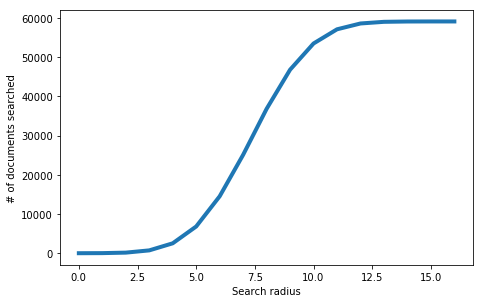

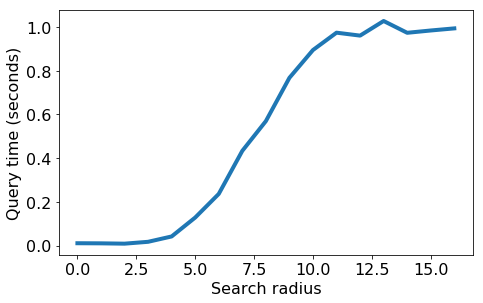

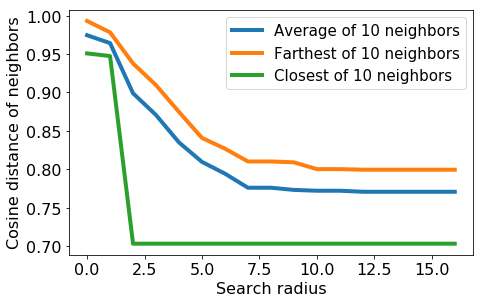

In [32]:
plt.figure(figsize=(7,4.5))
plt.plot(num_candidates_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(query_time_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(average_distance_from_query_history, linewidth=4, label='Average of 10 neighbors')
plt.plot(max_distance_from_query_history, linewidth=4, label='Farthest of 10 neighbors')
plt.plot(min_distance_from_query_history, linewidth=4, label='Closest of 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

Some observations:

* As we increase the search radius, we find more neighbors that are a smaller distance away.
* With increased search radius comes a greater number documents that have to be searched. Query time is higher as a consequence.
* With sufficiently high search radius, the results of LSH begin to resemble the results of brute-force search.

In [33]:
for i, v in enumerate(average_distance_from_query_history):
    if v <= 0.78:
        print(i, v)

7 0.7759826058523336
8 0.7759826058523336
9 0.7731349875446499
10 0.772070052411731
11 0.772070052411731
12 0.7707191289494767
13 0.7707191289494767
14 0.7707191289494767
15 0.7707191289494767
16 0.7707191289494767


## Quality metrics for neighbors

The above analysis is limited by the fact that it was run with a single query, namely Barack Obama. We should repeat the analysis for the entirety of data. Iterating over all documents would take a long time, so let us randomly choose 10 documents for our analysis.

For each document, we first compute the true 25 nearest neighbors, and then run LSH multiple times. We look at two metrics:

* Precision@10: How many of the 10 neighbors given by LSH are among the true 25 nearest neighbors?
* Average cosine distance of the neighbors from the query

Then we run LSH multiple times with different search radii.

In [34]:
def brute_force_query(vec, data, k):
    num_data_points = data.shape[0]
    
    # Compute distances for ALL data points in training set
    nearest_neighbors = pd.DataFrame(index=range(num_data_points))
    nearest_neighbors['distance'] = pairwise_distances(data, vec, metric='cosine').flatten()
    
    return nearest_neighbors.sort_values(by='distance', ascending = True)[:k]

The following cell will run LSH with multiple search radii and compute the quality metrics for each run. Allow a few minutes to complete.

In [35]:
max_radius = 17
precision = {i:[] for i in range(max_radius)}
average_distance  = {i:[] for i in range(max_radius)}
query_time  = {i:[] for i in range(max_radius)}

np.random.seed(0)
num_queries = 10
for i, ix in enumerate(np.random.choice(corpus.shape[0], num_queries, replace=False)):
    print('%s / %s' % (i, num_queries))
    ground_truth = set(brute_force_query(corpus[ix,:], corpus, k=25).index)
    # Get the set of 25 true nearest neighbors
    
    for r in range(1,max_radius):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=r)
        end = time.time()

        query_time[r].append(end-start)
        # precision = (# of neighbors both in result and ground_truth)/10.0
        precision[r].append(len(set(result.index) & ground_truth)/10.0)
        average_distance[r].append(result['distance'][1:].mean())

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10


Let's plot:

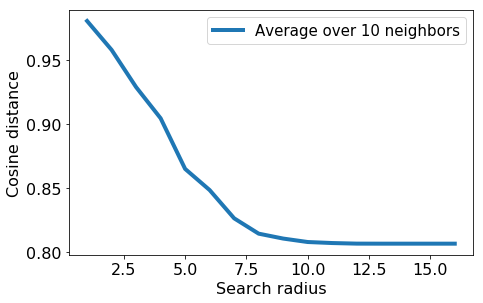

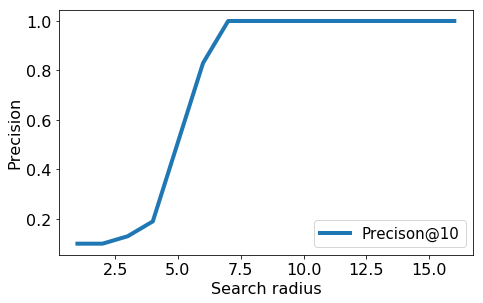

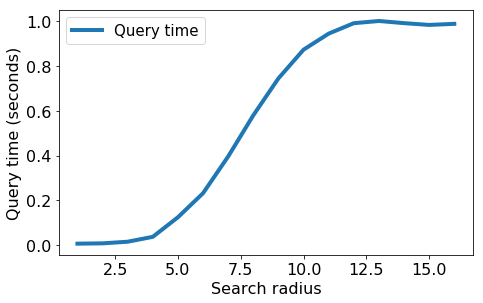

In [36]:
plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(average_distance[i]) for i in range(1,17)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(precision[i]) for i in range(1,17)], linewidth=4, label='Precison@10')
plt.xlabel('Search radius')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(query_time[i]) for i in range(1,17)], linewidth=4, label='Query time')
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

## Effect of number of random vectors

Let us now turn our focus to the remaining parameter: the number of random vectors. We run LSH with different number of random vectors, ranging from 5 to 20. We fix the search radius to 3.

In [37]:
# Effect of number of random vectors
precision = {i:[] for i in range(5,20)}
average_distance  = {i:[] for i in range(5,20)}
query_time = {i:[] for i in range(5,20)}
num_candidates_history = {i:[] for i in range(5,20)}
ground_truth = {}

np.random.seed(0)
num_queries = 10
docs = np.random.choice(corpus.shape[0], num_queries, replace=False)

for i, ix in enumerate(docs):
    ground_truth[ix] = set(brute_force_query(corpus[ix,:], corpus, k=25).index)
    # Get the set of 25 true nearest neighbors

for num_vector in range(5,20):
    print('num_vector = %s' % (num_vector))
    model = train_lsh(corpus, num_vector, seed=143)
    
    for i, ix in enumerate(docs):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=3)
        end = time.time()
        
        query_time[num_vector].append(end-start)
        precision[num_vector].append(len(set(result.index) & ground_truth[ix])/10.0)
        average_distance[num_vector].append(result['distance'][1:].mean())
        num_candidates_history[num_vector].append(num_candidates)

num_vector = 5
num_vector = 6
num_vector = 7
num_vector = 8
num_vector = 9
num_vector = 10
num_vector = 11
num_vector = 12
num_vector = 13
num_vector = 14
num_vector = 15
num_vector = 16
num_vector = 17
num_vector = 18
num_vector = 19


Plot the metrics as a function of the number of random rectors using the following piece of code :

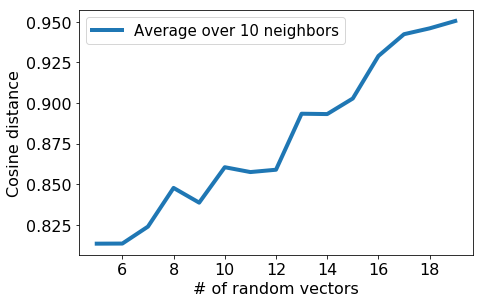

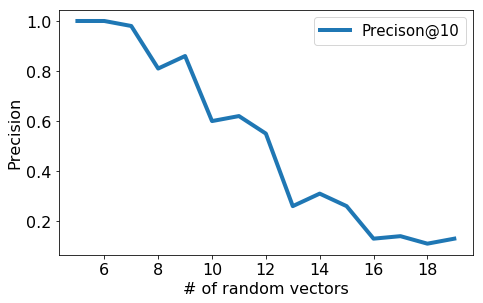

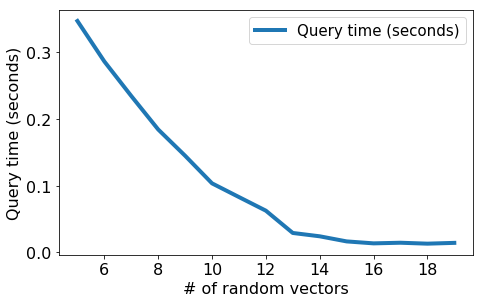

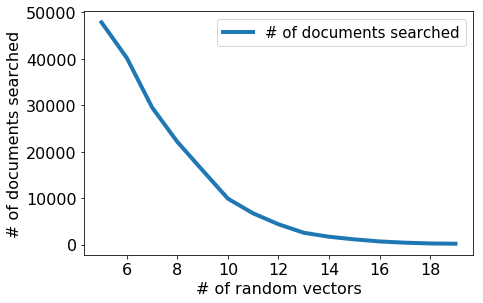

In [38]:
# Plot
plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(average_distance[i]) for i in range(5,20)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('# of random vectors')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(precision[i]) for i in range(5,20)], linewidth=4, label='Precison@10')
plt.xlabel('# of random vectors')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(query_time[i]) for i in range(5,20)], linewidth=4, label='Query time (seconds)')
plt.xlabel('# of random vectors')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(num_candidates_history[i]) for i in range(5,20)], linewidth=4,
         label='# of documents searched')
plt.xlabel('# of random vectors')
plt.ylabel('# of documents searched')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

We see a similar trade-off between quality and performance: as the number of random vectors increases, the query time goes down as each bin contains fewer documents on average, but on average the neighbors are likewise placed farther from the query. On the other hand, when using a small enough number of random vectors, LSH becomes very similar brute-force search: Many documents appear in a single bin, so searching the query bin alone covers a lot of the corpus; then, including neighboring bins might result in searching all documents, just as in the brute-force approach.